<a href="https://colab.research.google.com/github/gabiacuna/KL2021/blob/main/Analisis%20de%20Imagenes%20con%20DL/005-Transfer-Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning en Pytorch

El concepto de transfer learning es un método donde el modelo que ya fue entrenado para una
aplicación es utilizado para otra aplicación. Por ejemplo, uno puede utilizar un modelo ya
*pre-entrenado* como punto de partida para desarrollar un modelo para una segunda aplicación.

En computer visión, esto es algo común que se utiliza y que ha demostrado una gran ventaja.

## Transferir aprendizaje con datos de imágenes

Es común realizar el aprendizaje por transferencia con problemas de modelado predictivo que utilizan datos de imagen como entrada.

Esta puede ser una tarea de predicción que toma fotografías o datos de video como entrada.

Para este tipo de problemas, es común utilizar un modelo de aprendizaje profundo previamente entrenado para una tarea de clasificación de
imágenes grande y desafiante, como la competencia de clasificación de fotografías de la clase [ImageNet](https://www.image-net.org/) 1000.

<img src="https://cv.gluon.ai/_images/imagenet_banner.jpeg" alt="neural_network" style="width: 700px;" align="center"/>

Dentro de "transfer learning", se destacan varios modelos. Por ejemplo:
- Modelo Oxford VGG
- Modelo Microsoft ResNet

Una de las razones por las que el "transfer learning" es llamativo es porque se puede utilizar
cuando uno tiene un **número pequeño o limitado de data**. 

Si quieren ver más sobre otros modelos que se han hecho públicos y ya están entrenados, se pueden dirigir a [Model Zoo](https://github.com/BVLC/caffe/wiki/Model-Zoo) en Github.

### Cómo funciona el transfer learning

Uno puede pensar sobre "transfer learning' como un problema de optimización, en donde se trata de
optimizar las **últimas capas** del modelo y reentrenarlas para la aplicación de uno.

1. Uno entrena un modelo con una gran cantidad de data.
    - Ya tenemos las pesas, y es entrenado con cosas muy variadas.
2. Ya que el modelo es entrenado, éste se puede utilizar para crear una aplicación bien general que se puede aplicar a varios problemas.
3. Si uno quiere utilizar este modelo para algo especifico, uno entrena solamente la parte final de la red con la data que no tiene.
    - Las pesas de ciertas capas no se tocan. 

La siguiente imagen representa el concept de "transfer learning" a más detalle:

<img src="https://i0.wp.com/neptune.ai/wp-content/uploads/Transfer-learning-idea.jpg?resize=768%2C432&ssl=1" alt="neural_network" style="width: 700px;" align="center"/>

Más específico:

<img src="https://i0.wp.com/neptune.ai/wp-content/uploads/Transfer-learning-steps.png?w=921&ssl=1" alt="neural_network" style="width: 700px;" align="center"/>
<img src="https://i0.wp.com/neptune.ai/wp-content/uploads/Transfer-learning-steps-2.png?w=850&ssl=1" alt="neural_network" style="width: 700px;" align="center"/>

Se restringe el modelo que ya tenemos, y se reentrena con nuestra data
[resumen k encontre en google](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-deep-learning-tips-and-tricks)

Reentrenamos solo la ultima capa, incluso se cambian las posibles salidas.

## Ejemplo de Transfer Learning

En el siguiente tutorial, trataremos de clasificar imágenes de *abejas* y *hormigas*. Utilizaremos la data de 120
imágenes por cada clase para entrenar el modelo, y luego validaremos los resultados con 75 imágenes de *abejas* y
*hormigas*. El concepto de este tutorial fue adquirido de acá: [Link](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

### Descargando la data

Lo primero que tendremos que hacer es descargar la data necesaria:

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from pathlib import Path

In [2]:
# Data para transfer learning
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip .
    
# Creando directorio donde se bajará la data:
transfer_learning_directorio = Path(".").joinpath("transfer_learning_data").resolve()
transfer_learning_directorio.mkdir(exist_ok=True, parents=True)
# extract it in the current folder
!unzip hymenoptera_data.zip -d ./transfer_learning_data

--2021-07-02 23:11:53--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.84.206.26, 99.84.206.82, 99.84.206.63, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.84.206.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   220MB/s    in 0.2s    

2021-07-02 23:11:53 (220 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

--2021-07-02 23:11:53--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2021-07-02 23:11:53--
Total wall clock time: 0.3s
Downloaded: 1 files, 45M in 0.2s (220 MB/s)
Archive:  hymenoptera_data.zip
   creating: ./transfer_learning_data/hymenoptera_data/
   creating: ./transfer_learning_data/hymenoptera_data/train/
   creating: ./transfer_learning_data/hyme

### Normalización y transformación de la data

El siguiente paso es preparar la data para que se pueda usar en el modelo pre-entrenado:

In [3]:
# Augmentación de data:
# Un metodo para entrenar modelos de Deep Learning con imágenes es modificar la "apariencia" de
# las imágenes que se utilizan para el entrenamiento. Por ejemplo, se acostumbra a
# rotar las imágenes, normalizar los datos de la imágenes, etc. para que el modelo pueda
# aprender más "razgos" de las imágenes y por ende desarrollar un mejor modelo.
# 
# 
# Para las imágenes de validación, solamente normalizamos las imágenes.
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  #Cortamos aleatoriamente la imagen
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

Estas transformaciónes son solamente para que las imágenes de entrenamiento
y validación tengan las dimensiones correctas para el modelo.

### Definición de los datasets

El siguiente paso es la definición de los datasets:

In [4]:
# Folder en el cuál se encuentran los archivos
data_dir = 'transfer_learning_data/hymenoptera_data'

# Creamos un diccionario para el "training" y "validation" tiene las direcciones de losdirectorios
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

# Creamos un "DataLoader", el cual nos dará las imágenes cada vez que las pidamos
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

# Extraemos los tamaños de los datasets
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# Los nombres de las diferentes clases
class_names = image_datasets['train'].classes

# Por último, definimos el dispositivo sobre el cuál se ejecutará el entrenamiento
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [5]:
len(dataloaders['train'])

61

In [6]:
dataset_sizes

{'train': 244, 'val': 153}

In [7]:
class_names

['ants', 'bees']

In [8]:
from multiprocessing import cpu_count

In [9]:
cpu_count() #Retorna el numero de cpus k se tienen

2

### Examinando la data

Ya que hemos definido los diferentes datasets para el **entrenamiento** y la **validación**,
podemos visualizar algunas de las imágnes como parte de nuestro EDA:

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


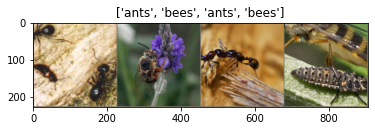

In [13]:
def imshow(inp, title=None):
    """
    Función para visualizar las imágenes
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Agarramos un cierto número de datos y extraemos
# las imágenes y sus respectivos etiquetas ("labels").
# Esta es parte de la data de "entrenamiento"
inputs, classes = next(iter(dataloaders['train']))

# Creamos una figura con varias imágenes y las visualizamos
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Entrenamiento del modelo

La siguiente parte vamos a entrenar el modelo con las imágenes que tenemos.
Primero definiremos ciertas funciones que se usarán a lo largo del tutorial:

#### Función de entrenamiento
Esta función es la función principal para entrenar un modelo:

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    """
    Función para entrenar un modelo.
    
    Parámetros
    -------------
    model :
        Modelo que se utiliza y se está entrenando.
    
    criterion :
        Criterio que se utiliza como el "loss function".
    
    optimizer :
        Optimizador para modificar las pesas del modelo.
    
    scheduler :
        Objeto que modifica la "velocidad de aprendizaje"
        luego de un cierto número de épocas.
    
    num_epochs : int
        Número total de épocas a utilizar para entrenar
        el modelo.
    """
    # Empieza el entrenamiento
    since = time.time()
    
    # Copiando las pesas actuales del modelo
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # Inicializando el valor de la "precisión" (accuracy)
    best_acc = 0.0

    # Es en este "loop" en donde empezamos a entrenar el modelo
    # y el modelo empieza a aprender de la data dada.
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Cada época tiene 2 fases: entrenamiento y validación
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Hace que el modelo entre en modo de "entrenamiento"
            else:
                model.eval()   # Hace que el modelo entre en modo de "validación"

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.   
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Es en esta parte donde se aplica el
                    # "backpropagation" y optimización de las pesas
                    # NOTA: Esto solamente sucede durante el **entrenamiento**
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()    #Cada cierta cantidad de epocas disminuye la velocidad de aprendizaje

                # Recolectamos ciertas estadísticas del modelo
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Copiamos el modelo y lo preparamos para iniciar de nuevo
            if phase == 'val' and epoch_acc > best_acc: #Comparamos el modelo anterior con el nuevo
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Descargamos las pesas más óptimas del modelo
    model.load_state_dict(best_model_wts)
    return model

En cada epoca se itera sobre la data.

La siguiente función es para visualizar los resultados del modelo:

In [17]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()    #Cambiamos a modo de evaluacion ( no cambian las pesas)
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():   #Evita que se cambien las pesas
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            # Este paso manda estos objectos al "dispositivo", i.e. "cpu" o "gpu".
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # En este paso el modelo crea predicciones
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Mejorando el modelo pre-entrenado

Es ahora en esta fase donde podemos utilizar un modelo que ya haya sido completamente
entrenado con data similar a la que tenemos.

#### foto arqui resnet18

<img src = 'https://i.imgur.com/XwcnU5x.png'/>

Sobre las redes de convoluciones [link](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1)

Para este ejemplo, utilizaremos el modelo **ResNet18** y utilizaremos sus pesas al principio:

In [18]:
model_ft = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


In [20]:
model_ft.fc.in_features #Este es el numero de redes de esta arqui, la salida de la red es de 512 features

512

In [21]:
class_names

['ants', 'bees']

In [22]:
# Inicializamos el modelo y extraemos el número total de "features"
model_ft = models.resnet18(pretrained=True) #Esto baja el modelo ya entrenado (con False tenemos el modelo no entrenado)
num_ftrs = model_ft.fc.in_features

# En esta parte se define el "fully-connected" (fc) layer, la cual se utilizará
# para definir el número total de clases que queremos. En este caso,
# estamos interesaos en ``2`` clases, y por ellos definimos **2** con parte
# de la arquitectura del modelo.
# 
# Esto se puede generalizar a ``nn.Linear(num_ftrs, len(class_names))``,
# dependiendo del número total de clasificaciones que queremos.
model_ft.fc = nn.Linear(num_ftrs, 2)
# Mandamos el objecto al dispositivo
model_ft = model_ft.to(device)

# En este caso decidimos el criterio / "loss function" de nuestro modelo.
# Utilizaremos el ``CrossEntropyLoss`` que se utiliza frequentemente para
# modelos de clasificación.
criterion = nn.CrossEntropyLoss()       #Funcion de perdida

# Definimos el "optimizador" y miramos que todos los parámetros del modelo
# sean optimizados.
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)     #momentum ,empuje al optimizador

# Finalmente podemos decidir un factor, por el cuál la "velocidad de entrenamiento"
# se reducirá después de cierto número de épocas.
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)    #Como variamos la velocidad del entrenamiento

[CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

#### Entrenando y evaluando los modelos

La última fase de entrenamiendo es ... entrenar el modelo. Uno puede definir si quiere entrenar
este modelo en un **CPU** o un **GPU**:

In [23]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.8061 Acc: 0.6762
val Loss: 0.4865 Acc: 0.8889

Epoch 1/24
----------
train Loss: 0.6954 Acc: 0.7623
val Loss: 0.4164 Acc: 0.8235

Epoch 2/24
----------
train Loss: 0.7328 Acc: 0.7336
val Loss: 0.3121 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.5579 Acc: 0.8033
val Loss: 0.2250 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.2999 Acc: 0.8852
val Loss: 0.2856 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.5809 Acc: 0.7910
val Loss: 0.2119 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.4957 Acc: 0.7910
val Loss: 0.2588 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.2785 Acc: 0.8770
val Loss: 0.2890 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.3011 Acc: 0.8689
val Loss: 0.2654 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.2452 Acc: 0.8975
val Loss: 0.3015 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.2782 Acc: 0.8852
val Loss: 0.2729 Acc: 0.9020

Epoch 11/24
----------
train Loss: 0.2669 Acc: 0.9016
val Loss: 0.2736 Acc: 0.9216

Epoch 12/24
----------
t

Ahora podemos visualizar algunas de las predicciones del modelo:

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


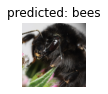

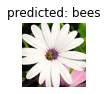

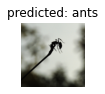

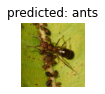

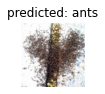

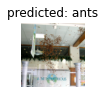

In [30]:
visualize_model(model_ft)

#### Entranando de nuevo el modelo, pero con nuestra data.

Ahora que ya hemos entrenado nuestro modelo con un modelo pre-entrenado, ahora podemos
cambiar de estrategia y utilizar "transfer learning" para entrenar otro modelo con nuestros datos:

In [26]:
# Ahora vamos a utilizar las pesas de este modelo y entrenarlo con nuestra data.
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():   #Revizamos los paramentros optilizados del modelo
    param.requires_grad = False     #decimos k no calcule las derivadas

# Volvemos a definir la forma del "fully-connected" layer para que tengo una salida
# de *2* clases.
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

# Mandamos el objeto al "CPU" o "GPU"
model_conv = model_conv.to(device)

# Loss function / Criterio
criterion = nn.CrossEntropyLoss()

# En este caso los parámetros de la "última capa" son optimizados.
# En el ejemplo anterior, esto no fue así.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Finalmente podemos decidir un factor, por el cuál la "velocidad de entrenamiento"
# se reducirá después de cierto número de épocas.
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Una vez más entrenamos el modelo:

In [27]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6187 Acc: 0.6639
val Loss: 0.5311 Acc: 0.7647

Epoch 1/24
----------
train Loss: 0.6075 Acc: 0.7295
val Loss: 0.2115 Acc: 0.9542

Epoch 2/24
----------
train Loss: 0.4152 Acc: 0.8033
val Loss: 0.2118 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.4204 Acc: 0.8074
val Loss: 0.3062 Acc: 0.8758

Epoch 4/24
----------
train Loss: 0.3974 Acc: 0.8197
val Loss: 0.1999 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.4685 Acc: 0.8074
val Loss: 0.1936 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.5083 Acc: 0.7951
val Loss: 0.2148 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.3455 Acc: 0.8484
val Loss: 0.1870 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.2929 Acc: 0.8730
val Loss: 0.2322 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.3992 Acc: 0.8197
val Loss: 0.1976 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3226 Acc: 0.8361
val Loss: 0.1819 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3416 Acc: 0.8648
val Loss: 0.1867 Acc: 0.9477

Epoch 12/24
----------
t

Y visualizamos los resultados:

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


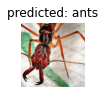

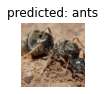

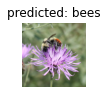

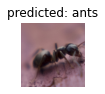

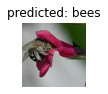

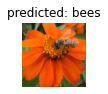

In [29]:
visualize_model(model_conv)

plt.ioff()
plt.show()